## 4\. Model Building

Now that we have the data ready, its time to start making predictive models. I will go through 5 scikit-learn simple models including linear regression, decision tree and random forest.

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

I'll do the same thing later with H2O and XGboost

In [1]:
import pandas as pd
import numpy as np
import time
import csv
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [3]:
use_validation=True
scale_numericals=False

In [4]:
#now we load our modified train and test set
tic()
sufix=""
if (use_validation): sufix += "_holdout"
if (scale_numericals): sufix += "_scaled"
print ("sufix: "+sufix)

train = pd.read_csv("./input-data/train_modified"+sufix+".csv",
                    dtype = {'Canal_ID': 'int8',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int8',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8',
                            'Cliente_ID_clust_ID':'int8'},
                   )
if (use_validation):                    
    val = pd.read_csv("./input-data/val_modified"+sufix+".csv",
                    dtype = {'Canal_ID': 'int8',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int8',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8',
                            'Cliente_ID_clust_ID':'int8'},
                   ) 
    
test = pd.read_csv("./input-data/test_modified"+sufix+".csv",
                    dtype = {'id': 'uint32',
                            'Canal_ID': 'int8',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'int8',
                            'prodtype_cluster': 'int8',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8',
                            'Cliente_ID_clust_ID':'int8'},
                      )
tac()

sufix: _holdout
Time passed: 0hour:0min:51sec


In [5]:
val.head()

,Canal_ID,log_target,pairs_mean,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,Log_Target_mean_lag4,Log_Target_mean_lag5,Lags_sum,brand,prodtype_cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID,Cliente_ID_clust_ID
0,7,0.693147,1.599232,1.609438,0.000000,0.000000,1.791759,1.609438,5.010635,1,18,1,2008,1,11,21,41,5,70
1,7,1.098612,1.212066,1.386294,1.098612,1.098612,0.693147,1.386294,5.662960,1,2,1,2008,1,11,21,41,5,70
2,7,1.098612,1.746179,1.098612,2.197225,0.000000,0.000000,2.079442,5.375278,1,14,1,2008,1,11,39,41,5,70
3,7,0.693147,1.174876,0.693147,1.098612,1.386294,1.098612,1.386294,5.662960,1,25,1,2008,1,11,5,41,5,70
4,7,2.397895,1.828950,2.197225,2.708050,0.693147,2.197225,1.386294,9.181941,1,25,1,2008,1,11,14,41,5,70


In [6]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [28]:
#   rmsle - error function used in LB
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(max(0,y_pred[i]) + 1) - math.log(max(0,y[i]) + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    y = alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])

    #Perform cross-validation: We are not using CV since the data has a temporal behavior, aka, time series.
    #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=2, scoring='mean_squared_error')
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    #print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    #print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #RMSLE Option 1: - using the rsmle function defined above
    #print ('RMSLE TRAIN: ', rmsle(np.expm1(dtrain[target].values), np.expm1(dtrain_predictions)))  
    #print ('RMSLE VAL: ', rmsle(np.expm1(dval[target].values), np.expm1(dval_predictions)))
    
    #RMSLE Option 2: the fastest one
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
    
        
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(alg.predict(dtest[predictors]))
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    dtest[target] = np.maximum(dtest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    
    

Let's define now the target and the Id cols

### Alg1 - Linear Regression Model

Lets make our first linear-regression model


Model Report
RMSLE TRAIN:  0.312136511846
RMSLE VAL:  0.514920934154
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  28824
MIN TARGET PREDICTED:  -0.091566523105
MEAN TARGET PREDICTED:  7.484396485436637
MAX TARGET PREDICTED:  7992.50031345
Time passed: 0hour:0min:39sec


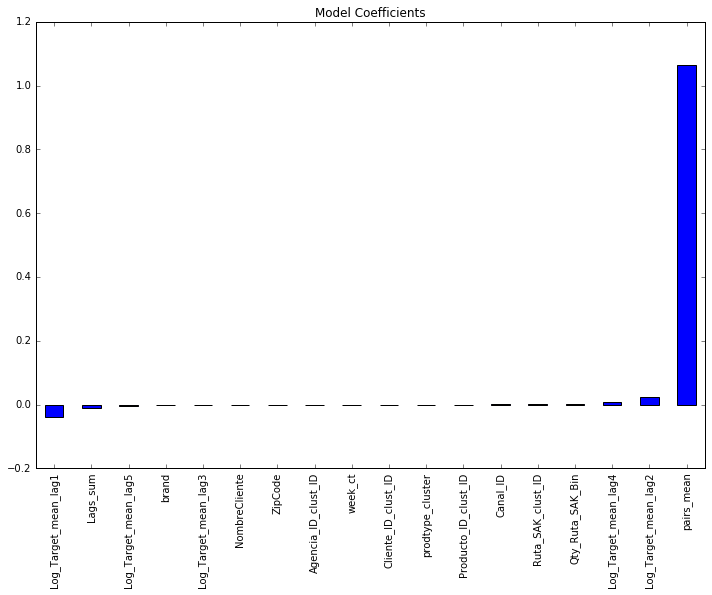

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+[IDcol]]

# print predictors
model = LinearRegression()
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg1.csv')
tac()
coef1 = pd.Series(model.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

The difference in rsmle in train vs val set is too high, this means overfitting.
We can see the reason of the overfit when looking at the coefficients, one in particular is very large in magnitude which causes the overfitting. To cater to this, lets use a ridge regression model.

### Alg2 - Ridge Regression Model:


Model Report
RMSLE TRAIN:  0.327946943938
RMSLE VAL:  0.496237212861
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.104586125643
MEAN TARGET PREDICTED:  5.960874976026391
MAX TARGET PREDICTED:  2048.37779012
Time passed: 0hour:0min:47sec


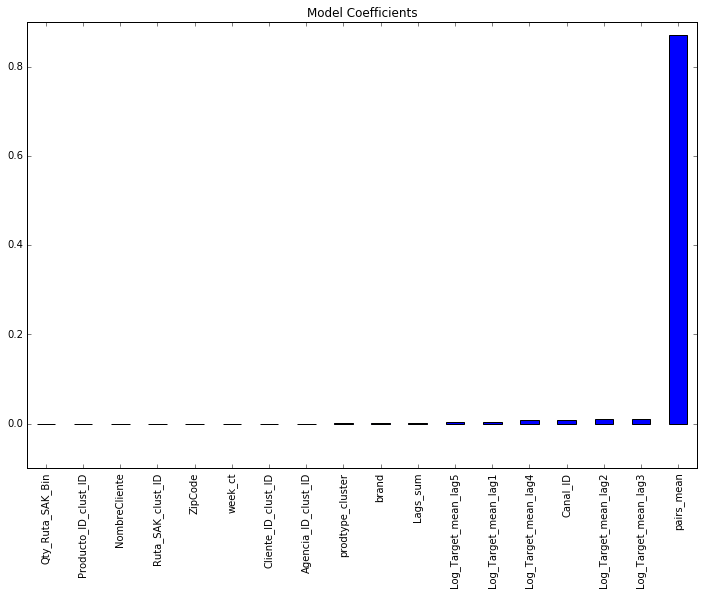

In [23]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'pairs_mean', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'week_ct',
              'NombreCliente', 'Producto_ID_clust_ID', 'Ruta_SAK_clust_ID', 'Agencia_ID_clust_ID', 'Cliente_ID_clust_ID']
model = Ridge(alpha=0.1, normalize=True, solver="sag")
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg2.csv')
tac()
coef2 = pd.Series(model.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

Though the train vs val rsmle difference is still high we noticed a improvement on the score, but still  the pairs_mean is taking all the weight/importance. We can tune the parameters of the model  but I don’t think there will be a significant improvement with linear regression.

Let's analize this behaviour for a minute, ~0.5 is basically the score of taking only pairs mean as the feature. This means that since pairs_mean is the average of demand per pair of product-client, we will be better of just doing the average and not do any machine learning at all (way faster). But I believe that the point of the competition is to predict, not to calculate an historical average. So let's remove it and actually try to predict.

Good news is that 0.5 is our baseline score we need to improve.

### Alg3 - Decision Tree Model

Lets try out a decision tree model and see if we get something better.


Model Report
RMSLE TRAIN:  0.475104272039
RMSLE VAL:  0.481007061543
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0145519958788
MEAN TARGET PREDICTED:  5.249997215358622
MAX TARGET PREDICTED:  194.86047605
Time passed: 0hour:2min:6sec


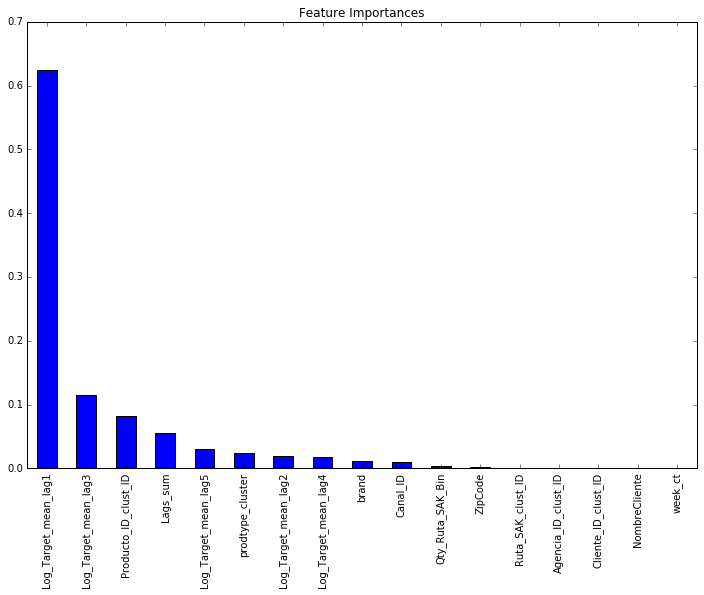

In [29]:
from sklearn.tree import DecisionTreeRegressor
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'week_ct',
              'NombreCliente', 'Producto_ID_clust_ID', 'Ruta_SAK_clust_ID', 'Agencia_ID_clust_ID', 'Cliente_ID_clust_ID']

model = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg3.csv')
tac()
coef3 = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

### Bingo!
- RSMLE TRAIN vs RSMLE VAL is good, no sign of overfitting.
- Our score improved to 0.48. 
- Some bad news is that the MAX TARGET PREDICTED is way different than the linear regression models. Min and Mean targets predicted look good though. This is an indication that the variance of our data is very high and our model cannot generalize well.

### Alg4 - Decision Tree Model v2

Lets try making a decision tree eliminating the variables with little importance, a max_depth of 25 and min_samples_leaf as 150.


Model Report
RMSLE TRAIN:  0.463982640291
RMSLE VAL:  0.47432799062
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.00652183960838
MEAN TARGET PREDICTED:  5.232495596872272
MAX TARGET PREDICTED:  167.683820935
Time passed: 0hour:1min:56sec


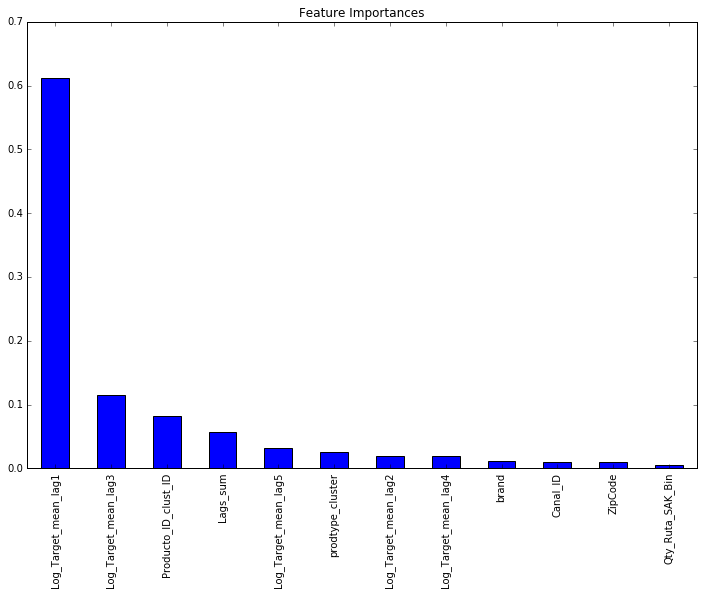

In [26]:
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']

model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=150)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg4.csv')
tac()
coef4 = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

As expected, we improved our score further (no we are in the 0.47 range), deleted some useless features, but are still seeing the problem of MAX TARGET PREDICTED being way off the linear regression models / pairs mean.

Let's try some ensembling algos, starting with Random Forest which is an ensemble of the trees above. Score should improve by book definition :)

### Alg5 - Random Forest Model


Model Report
RMSLE TRAIN:  0.462841142899
RMSLE VAL:  0.470629617906
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0234771641983
MEAN TARGET PREDICTED:  5.19141185199668
MAX TARGET PREDICTED:  131.487264368
Time passed: 0hour:11min:49sec


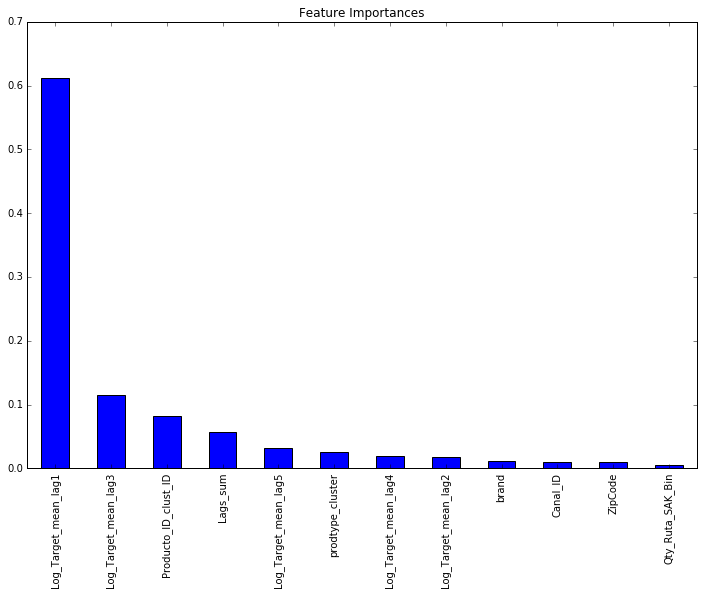

In [27]:
from sklearn.ensemble import RandomForestRegressor
predictors = ['Canal_ID', 'Log_Target_mean_lag1', 'Log_Target_mean_lag2', 'Log_Target_mean_lag3', 'Log_Target_mean_lag4', 
              'Log_Target_mean_lag5','Lags_sum', 'brand', 'prodtype_cluster', 'Qty_Ruta_SAK_Bin', 'ZipCode', 'Producto_ID_clust_ID']

model = RandomForestRegressor(n_estimators=100,max_depth=25, min_samples_leaf=150,n_jobs=-1)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg5.csv')
tac()
coef5 = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

As expected, better than a single tree. We can improve a little bit more if we add more estimators (trees), but Let's move on to more complex waters with XGBoost and H2O, where we also are going to deal with the fact that our MAX TARGET PREDICTED is very far from what it should be. This is a typical indication that our model is trying to predict clients that are very different in behaviour and we might not get too much better than this score. The solution to this is to create more granular models, or train as many models as client clusters are.

We just set a new bar: 0.47

See the next notebook ..